In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

from decimal import Decimal, ROUND_HALF_UP, getcontext

def round_measurement(value, error):
    """
    Rundet einen Messwert und seinen Fehler wissenschaftlich korrekt.

    Parameter:
    - value (float): Messwert.
    - error (float): Fehler des Messwerts.

    Rückgabewert:
    - rounded_value_str (str): Gerundeter Messwert als String.
    - rounded_error_str (str): Gerundeter Fehler als String.
    """
    getcontext().prec = 28
    val_dec = Decimal(str(value))
    err_dec = Decimal(str(error))

    if err_dec == 0:
        rounded_err = Decimal('0')
        rounded_val = val_dec
        dp_err = None
        dp_val = None

    else:
        # Exponent des Fehlers bestimmen
        exp_e = err_dec.normalize().adjusted()
        m = err_dec.scaleb(-exp_e)
        first_digit = int(m.to_integral_value(rounding=ROUND_HALF_UP))
        if first_digit in [1, 2]:
            significant_digits = 2
        else:
            significant_digits = 1
        exponent_LSD = exp_e - (significant_digits - 1)
        # Fehler aufrunden
        factor_err = Decimal('1e{}'.format(exponent_LSD))
        rounded_err = (err_dec / factor_err).to_integral_value(rounding=ROUND_HALF_UP) * factor_err
        # Bestimmen der Anzahl der Dezimalstellen für Fehler
        dp_err = max(-exponent_LSD, 0)
        dp_val = dp_err  # Der Wert wird auf die gleiche Stelle wie der Fehler gerundet
        # Quantisierungswert erstellen
        quantize_exp = Decimal('1e{}'.format(exponent_LSD))
        # Gerundeten Fehler und Wert quantisieren
        rounded_err = rounded_err.quantize(quantize_exp)
        rounded_val = val_dec.quantize(quantize_exp, rounding=ROUND_HALF_UP)

    # Formatierung, um nachgestellte Nullen zu erhalten
    if dp_val is not None:
        format_str = f'{{0:.{dp_val}f}}'
        rounded_value_str = format_str.format(rounded_val)
    else:
        rounded_value_str = str(rounded_val)

    if dp_err is not None:
        format_str = f'{{0:.{dp_err}f}}'
        rounded_error_str = format_str.format(rounded_err)
    else:
        rounded_error_str = str(rounded_err)

    return rounded_value_str, rounded_error_str


def mean_calc(z_input, err_input, goal='data weighting'):
    """
    Berechnet den gewichteten Mittelwert eines Wertearrays unter Berücksichtigung individueller Fehlerwerte.

    Parameter:
    - z_input (array_like): Array mit den zu gewichtenden Werten.
    - err_input (array_like): Array mit den Fehlern, die den Werten in z_input zugeordnet sind.
    - goal (str, optional): Bestimmt den Berechnungsmodus.
        - 'data weighting': Berechnet den gewichteten Mittelwert der Daten.
        - 'error': Berechnet den Fehler des Mittelwerts.
        Standardwert: 'data weighting'

    Rückgabewert:
    - mean_val (float): Der berechnete gewichtete Mittelwert oder der Fehler des Mittelwerts.
    """
    mean_1 = mean_2 = i = 0
    while i < len(z_input):
        mean_1 += (z_input[i] / err_input[i] ** 2)
        mean_2 += (1 / (err_input[i] ** 2))
        i += 1
    if goal == 'data weighting':
        mean_val = mean_1 / mean_2
    if goal == 'error':
        mean_val = np.sqrt(1 / mean_2)
    return mean_val
    

def geraden_fit(exp_nr, file_n, title='Titel', x_label='X-Achse', y_label='Y-Achse',
                save=False, length=15, height=5, x_axis=0, y_axis=0, result_length=4, 
                x_major_ticks=None, x_minor_ticks=None, y_major_ticks=None, y_minor_ticks=None,
                legendlocation='best', y_labels=None, y_markers=None, y_colors=None, 
                x_decimal_places=1, y_decimal_places=1, Ursprungsgerade=False, custom_datavol_limiter=0,
                linear_fit=False, focus_point=False, plot_y_inter = False, y_inter_label = None, x_shift = 0, y_shift = 0):
    # Daten laden
    path = f'{exp_nr}/{file_n}.txt'
    data = np.loadtxt(path, ndmin=1)
    x_val, x_err = data[:, 0] + x_shift, data[:, 1]
    y_data = data[:, 2:]
    
    # Überprüfen, ob die Anzahl der y-Spalten gerade ist
    if y_data.shape[1] % 2 != 0:
        raise ValueError("Die Anzahl der y-Spalten muss gerade sein (Paare von y und y_err).")
    
    n_datasets = y_data.shape[1] // 2  # Anzahl der y-Datensätze
    
    # Labels, Marker und Farben vorbereiten
    if y_labels is None:
        y_labels = [f'Datensatz {i+1}' for i in range(n_datasets)]
    if y_markers is None:
        y_markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', '+', 'x', 'd']
    if y_colors is None:
        cmap = plt.cm.get_cmap('tab10')
        y_colors = [cmap(i) for i in range(n_datasets)]
    
    fig, ax = plt.subplots(figsize=(length, height))
    
    # Achsen bei x=0 und y=0 hinzufügen
    ax.axhline(y_axis, color='black', linewidth=1.5)
    ax.axvline(x_axis, color='black', linewidth=1.5)
    
    # Begrenzter Wertebereich für die Ursprungsgerade initialisieren
    overall_min_x = np.inf
    overall_max_x = -np.inf
    
    # Jeden Datensatz plotten
    for i in range(n_datasets):
        y_val = y_data[:, 2*i] + y_shift
        y_err = y_data[:, 2*i + 1]
    
        # Begrenzen der Daten, falls custom_datavol_limiter gesetzt ist
        limit = custom_datavol_limiter if custom_datavol_limiter > 0 else len(x_val)
        x_val_limited = x_val[:limit]
        x_err_limited = x_err[:limit]
        y_val_limited = y_val[:limit]
        y_err_limited = y_err[:limit]
    
        n = len(x_val_limited)
    
        # Aktualisieren der Grenzen für die Ursprungsgerade
        overall_min_x = min(overall_min_x, min(x_val_limited))
        overall_max_x = max(overall_max_x, max(x_val_limited))
    
        label = y_labels[i] if i < len(y_labels) else f'Datensatz {i+1}'
        marker = y_markers[i % len(y_markers)]
        color = y_colors[i % len(y_colors)]
        ax.errorbar(x_val_limited, y_val_limited, xerr=x_err_limited, yerr=y_err_limited,
                    marker=marker, capsize=3, linestyle='none', label=label, color=color)
    
        if linear_fit:
            # Berechnungen
            x_mean = mean_calc(x_val_limited, y_err_limited)
            y_mean = mean_calc(y_val_limited, y_err_limited)
            xty_mean = mean_calc(x_val_limited * y_val_limited, y_err_limited)
            xs_mean = mean_calc(x_val_limited ** 2, y_err_limited)
            y_err_mean = mean_calc(y_val_limited, y_err_limited, 'error')
    
            grad = (xty_mean - x_mean * y_mean) / (xs_mean - x_mean ** 2)
            y_inter = (xs_mean * y_mean - x_mean * xty_mean) / (xs_mean - x_mean ** 2)
            xy_err_mean = np.mean((y_err * np.sqrt(((x_err / x_val)/(y_err / (y_val-y_inter)))**2 + 1)))
            var_grad = xy_err_mean ** 2 / (n * (xs_mean - x_mean ** 2))
            var_inter = xy_err_mean ** 2 * xs_mean / (n * (xs_mean - x_mean ** 2))
    
            grad_err = np.sqrt(var_grad)
            y_inter_err = np.sqrt(var_inter)
    
            x_mean_err = np.sqrt(np.sum(x_err_limited**2)) / n  # Fehler des Mittelwerts
            y_mean_err = y_err_mean
    
            # Gerundete Werte erhalten
            grad_str, grad_err_str = round_measurement(grad, grad_err)
            y_inter_str, y_inter_err_str = round_measurement(y_inter, y_inter_err)
            x_mean_str, x_mean_err_str = round_measurement(x_mean, x_mean_err)
            y_mean_str, y_mean_err_str = round_measurement(y_mean, y_mean_err)

            # Schwerpunkt plotten
            if focus_point:
                ax.errorbar(x_mean, y_mean, yerr=y_mean_err, xerr=x_mean_err, marker='x', color='red', capsize=3,
                            label=f'Schwerpunkt {label}\n({x_mean_str}±{x_mean_err_str}, {y_mean_str}±{y_mean_err_str})')    
  
                
            # Berechnung der Regressionsgeraden
            # x_line = np.linspace(min(x_val_limited), max(x_val_limited), 100)
            x_line = np.linspace(0, max(x_val_limited), 100)
            best_fit = grad * x_line + y_inter
            stan_dev_1 = (grad + grad_err) * (x_line - x_mean) + y_mean
            stan_dev_2 = (grad - grad_err) * (x_line - x_mean) + y_mean
    
            # Regressionsgerade plotten
            ax.plot(x_line, best_fit, color=color, label=f'Fit {label}: m={grad_str}±{grad_err_str}')

            # Unsicherheitsgeraden plotten
            ax.plot(x_line, stan_dev_1, color=color, linestyle=':', label=f'Unsicherheit {label}')
            ax.plot(x_line, stan_dev_2, color=color, linestyle=':')
    
            # Y-Achsenabschnitt plotten
            if plot_y_inter:
                if y_inter_label == None:
                    ax.errorbar(0, y_inter, yerr=y_inter_err, marker='x', color='#ffc130', capsize=3,
                                label=f'Y-Achenabschnitt {label}\n({y_inter_str}±{y_inter_err_str})')   
                else:  
                    ax.errorbar(0, y_inter, yerr=y_inter_err, marker='x', color='#ffc130', capsize=3,
                                label=f'Y-Achenabschnitt {y_inter_label}\n({y_inter_str}±{y_inter_err_str})') 
                
            # Fit-Ergebnisse ausgeben
            print(f"Fit-Ergebnisse für {label}:")
            print(f"Schwerpunkt: ({x_mean_str} ± {x_mean_err_str}, {y_mean_str} ± {y_mean_err_str})")
            print(f"Steigung: {grad_str} ± {grad_err_str}")
            print(f"Y-Achsenabschnitt: {y_inter_str} ± {y_inter_err_str}\n")
    
    # Ursprungsgerade auf begrenzte Werte anpassen
    if Ursprungsgerade:
        line_range = np.linspace(overall_min_x, overall_max_x, 100)
        plt.plot(line_range, line_range, color="red", linestyle="--", label="Ursprungsgerade (y=x)")
    
    # Haupt- und Nebenticks setzen
    ax.xaxis.set_major_locator(MultipleLocator(x_major_ticks))
    ax.xaxis.set_minor_locator(MultipleLocator(x_minor_ticks))
    ax.yaxis.set_major_locator(MultipleLocator(y_major_ticks))
    ax.yaxis.set_minor_locator(MultipleLocator(y_minor_ticks))
    
    # Anzahl der Dezimalstellen für die Achsenlabels festlegen
    x_format_string = f'%.{x_decimal_places}f'
    y_format_string = f'%.{y_decimal_places}f'
    ax.xaxis.set_major_formatter(FormatStrFormatter(x_format_string))
    ax.yaxis.set_major_formatter(FormatStrFormatter(y_format_string))
    
    # Rasterlinien anpassen
    ax.grid(which='major', color='grey', linestyle='-', linewidth=0.75)
    ax.grid(which='minor', color='lightgrey', linestyle=':', linewidth=0.5)
    
    # Achsenbeschriftungen und Titel
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    
    # Legende anzeigen
    ax.legend(loc=legendlocation)
    
    if save:
        plt.savefig(f'{exp_nr}/_gf_{file_n}.png', bbox_inches='tight')
    
    plt.show()



Fit-Ergebnisse für $R$:
Schwerpunkt: (0.57 ± 0.03, 393.03 ± 0.12)
Steigung: 950 ± 160
Y-Achsenabschnitt: -150 ± 90



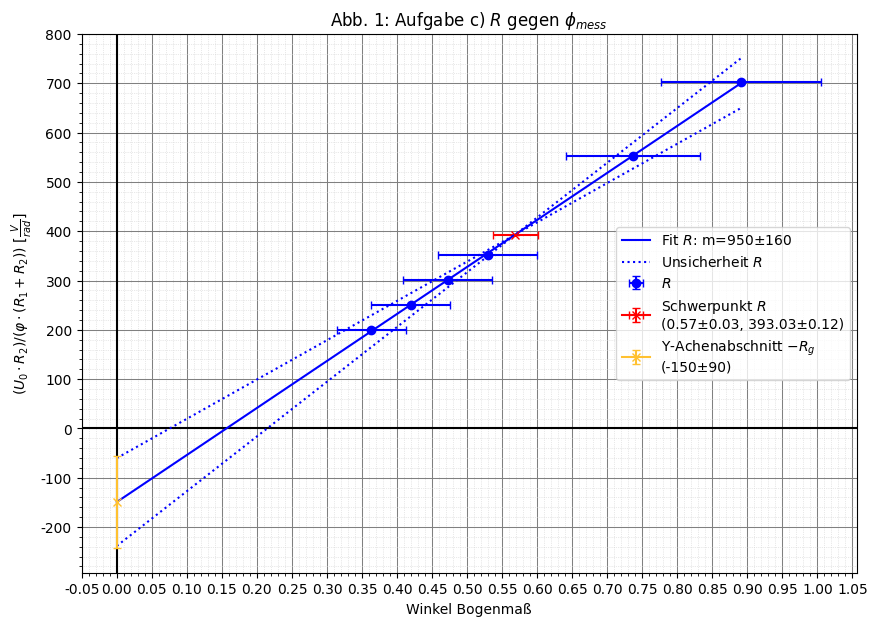

In [45]:
geraden_fit(
    exp_nr='236',
    file_n='c_rech_R_gg_Phi-1_mit_Faktor',
    title='Abb. 1: Aufgabe c) $R$ gegen $\phi_{mess}$',
    x_label='Winkel Bogenmaß',
    y_label = r'$(U_0 \cdot R_2) / (\varphi \cdot (R_1 + R_2))$ $[\frac{V}{rad}]$',
    save=True,
    length=10,
    height=7,
    x_axis=0,
    y_axis=0,
    x_major_ticks=0.05,   # Hauptticks alle 10 Einheiten
    x_minor_ticks=0.01,    # Nebenticks alle 1 Einheit
    y_major_ticks=100,
    y_minor_ticks=20,
    legendlocation='best',
    y_labels=['$R$'],  # Provide labels for each dataset
    y_inter_label = '$-R_g$',
    y_markers=['o'],       # Optional: specify markers
    y_colors=['blue'], # Optional: specify colors
    x_decimal_places=2,
    y_decimal_places=0,
    linear_fit=True,
    focus_point=True,
    plot_y_inter=True
)


Fit-Ergebnisse für $phi$:
Schwerpunkt: (0.0001275 ± 0.0000008, 0.123 ± 0.005)
Steigung: 990 ± 160
Y-Achsenabschnitt: -0.003 ± 0.022



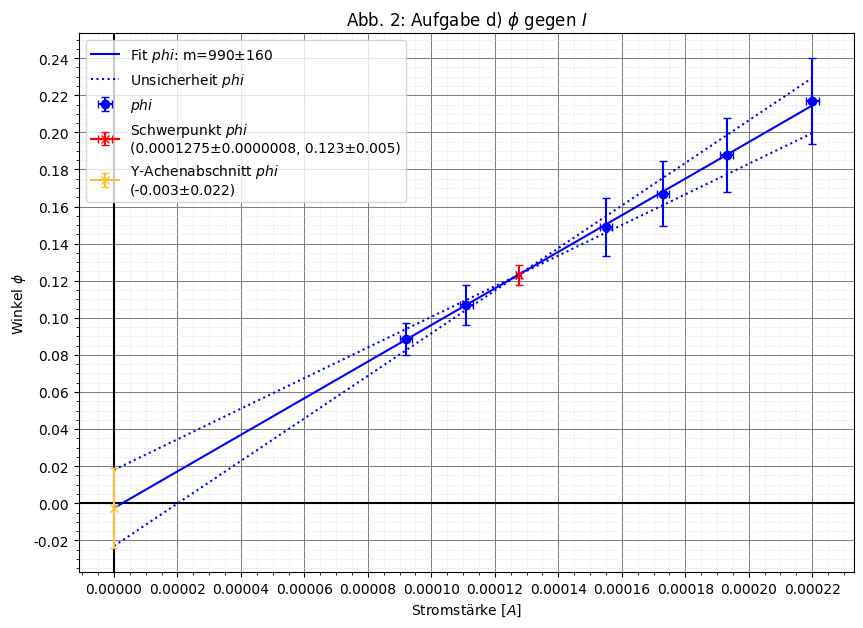

In [46]:
geraden_fit(
    exp_nr='236',
    file_n='c_rech_Phi_gg_I',
    title=r'Abb. 2: Aufgabe d) $\phi$ gegen $I$',
    x_label=r'Stromstärke [$A$]',
    y_label='Winkel $\phi$',
    save=True,
    length=10,
    height=7,
    x_axis=0,
    y_axis=0,
    x_major_ticks=0.00002,   # Hauptticks alle 10 Einheiten
    x_minor_ticks=0.000005,    # Nebenticks alle 1 Einheit
    y_major_ticks=0.02,
    y_minor_ticks=0.005,
    legendlocation='best',
    y_labels=['$phi$'],  # Provide labels for each dataset
    y_markers=['o'],       # Optional: specify markers
    y_colors=['blue'], # Optional: specify colors
    y_decimal_places=2,
    x_decimal_places=5,
    linear_fit=True,
    focus_point=True,
    plot_y_inter=True,
    x_shift = 0,
    y_shift = 0.0,
)


Fit-Ergebnisse für $phi$:
Schwerpunkt: (1.69 ± 0.03, 3.31 ± 0.04)
Steigung: -0.88 ± 0.17
Y-Achsenabschnitt: 4.8 ± 0.3



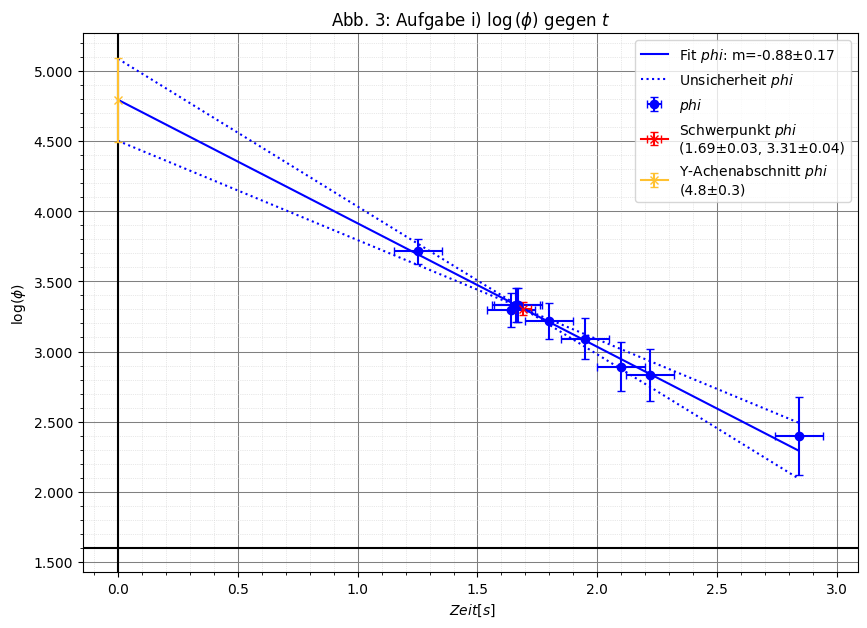

In [47]:
geraden_fit(
    exp_nr='236',
    file_n='i_rech_phi_gg_log_t',
    title=r'Abb. 3: Aufgabe i) $\log{(\phi)}$ gegen $t$',
    x_label=r' $Zeit [s]$',
    y_label=r'log($\phi$)',
    save=True,
    length=10,
    height=7,
    x_axis=0,
    y_axis=1.6,
    x_major_ticks=0.5,   # Hauptticks alle 10 Einheiten
    x_minor_ticks=0.1,    # Nebenticks alle 1 Einheit
    y_major_ticks=0.5,
    y_minor_ticks=0.1,
    legendlocation='best',
    y_labels=['$phi$'],  # Provide labels for each dataset
    y_markers=['o'],       # Optional: specify markers
    y_colors=['blue'], # Optional: specify colors
    y_decimal_places=3,
    x_decimal_places=1,
    linear_fit=True,
    focus_point=True,
    plot_y_inter=True,
    x_shift = 0,
    y_shift = 0,
)
